In [45]:
import xarray as xr
import numpy as np
import argparse
import os
import fdasrsf.curve_functions as curve_functions
import tqdm
import umap
#import umap.plot
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import classify_style
import sklearn.model_selection as model_selection
import classify_style
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
def equalize_fraglet_numbers(dataset):
    style_array = np.array(dataset.style.values)
    # Figure out maximum number by style
    styles, counts = np.unique(style_array, return_counts=True)
    print(counts)
    num_per_style = np.min(counts)
    full_selection = []
    for s in styles:
        indices = np.argwhere(style_array == s).squeeze()
        selection = np.random.choice(indices, size=num_per_style, replace=False)
        full_selection.append(selection)
    full_selection = np.sort(np.concatenate(full_selection))
    return dataset.isel(fraglet_id =full_selection)

In [47]:
class args:
    min_area = 400
    min_periphery_factor = 5

fragment_fraglets = classify_style.read_fraglets("../netcdf/style-frags-merge/", args())
codebook_fraglets = classify_style.read_fraglets("../netcdf/codebook-augmented", args())

# Equalize number of fragments by style
#codebook_fraglets = equalize_fraglet_numbers(codebook_fraglets)
classify_style.normalize_fraglets_simple(fragment_fraglets)
classify_style.normalize_fraglets_simple(codebook_fraglets)
# Get distribution of styles over classes


Reading fraglets images from ../netcdf/style-frags-merge/fraglets.nc
Read 136372 fraglets.
Remaining fraglets after filtering: 40449.
Reading fraglets images from ../netcdf/codebook-augmented/fraglets.nc
Read 50898 fraglets.
Remaining fraglets after filtering: 13126.


In [48]:
print(np.unique(fragment_fraglets.style.values, return_counts=True))
print(np.unique(codebook_fraglets.style.values, return_counts=True))

(array(['Archaic', 'Hasmonean', 'Herodian'], dtype=object), array([13832, 12854, 13763]))
(array(['Archaic', 'Hasmonean', 'Herodian'], dtype=object), array([1249, 6372, 5505]))


In [49]:
#classify_style.get_srvf(fragment_fraglets)
#classify_style.get_srvf(codebook_fraglets)

In [50]:
full_label = codebook_fraglets['style'].astype('str').str.cat(
    codebook_fraglets['allograph'].astype('str')
).values
full_label_encoder = LabelEncoder()
codebook_fraglets['full_label'] = ('fraglet_id', full_label_encoder.fit_transform(full_label))

style_label = codebook_fraglets['style'].astype('str').values
style_label_encoder = LabelEncoder()
codebook_fraglets['style_label'] = ('fraglet_id', style_label_encoder.fit_transform(style_label))

allo_label = codebook_fraglets['allograph'].astype('str').values
allo_label_encoder = LabelEncoder()
codebook_fraglets['allo_label'] = ('fraglet_id', allo_label_encoder.fit_transform(allo_label))


In [51]:
img_train, img_test = model_selection.train_test_split(codebook_fraglets.img_id, train_size=0.75, stratify=codebook_fraglets.style)

In [52]:
train_ds = codebook_fraglets.where(codebook_fraglets.img_id.isin(img_train), drop=True)
test_ds = codebook_fraglets.where(codebook_fraglets.img_id.isin(img_test), drop=True)

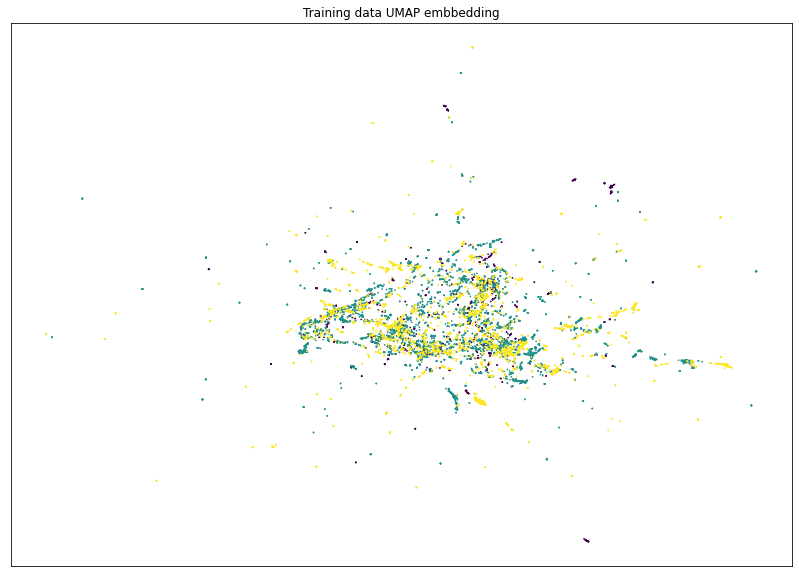

In [62]:
train_features = np.stack([train_ds['contour_norm'].values], axis = 2).reshape(-1,200)
feature_projection = umap.UMAP(
    min_dist=0.0,
    n_components=5,
    n_neighbors=30,
)
train_embedding = feature_projection.fit_transform(train_features, y=train_ds.full_label)
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*train_embedding[:,:2].T, s=0.5, c=train_ds.style_label, alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
plt.title('Training data UMAP embbedding');
plt.show()

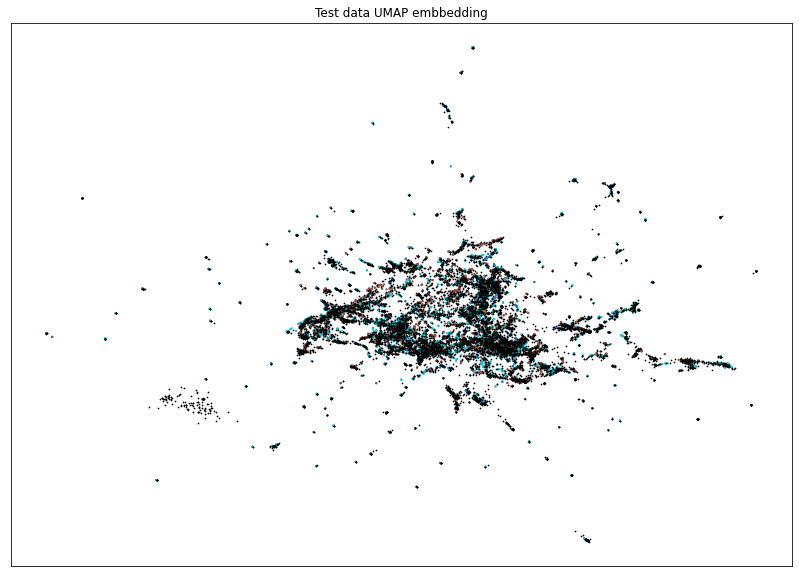

In [64]:
test_features = np.stack([test_ds['contour_norm'].values], axis = 2).reshape(-1,200)
test_embedding = feature_projection.transform(test_features)
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*train_embedding[:,:2].T, s=1.5, c=train_ds.style_label, alpha=1.0, cmap='tab10')
plt.scatter(*test_embedding[:,:2].T, s=0.5, alpha=1.0, c='k')
plt.setp(ax, xticks=[], yticks=[])
plt.title('Test data UMAP embbedding')
plt.show()

In [65]:
from sklearn.neighbors import KNeighborsClassifier
fraglet_style_knn = KNeighborsClassifier(n_neighbors=4)
fraglet_style_knn.fit(train_embedding, train_ds.style_label)
style_pred = fraglet_style_knn.predict(test_embedding)
print("Style prediction accuracy:", fraglet_style_knn.score(test_embedding, test_ds.style_label))


fraglet_full = KNeighborsClassifier(n_neighbors=10)
fraglet_full.fit(train_embedding, train_ds.full_label)
full_pred = fraglet_full.predict(test_embedding)
print("Full prediction accuracy: ", fraglet_full.score(test_embedding, test_ds.full_label))

fraglet_allo_knn = KNeighborsClassifier(n_neighbors=10)
fraglet_allo_knn.fit(train_embedding, train_ds.allo_label)
print("Allograph prediction accuracy:", fraglet_allo_knn.score(test_embedding, test_ds.allo_label))



Style prediction accuracy: 0.8346238938053098
Full prediction accuracy:  0.6827064896755162
Allograph prediction accuracy: 0.7229904129793511


In [66]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_ds.style_label, style_pred)

array([[ 773,  133,  106],
       [ 186, 4731,  471],
       [ 114,  784, 3550]])

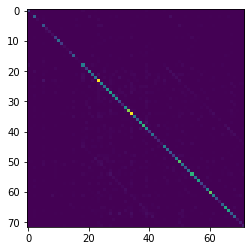

In [67]:
from sklearn.metrics import confusion_matrix
plt.imshow(confusion_matrix(test_ds.full_label, full_pred))

# Classify the fragments

In [ ]:
fragment_features = np.stack([fragment_fraglets['contour_norm'].values], axis = 2).reshape(-1,200)
fragment_embedding = feature_projection.transform(fragment_features)
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*train_embedding[:,:2].T, s=1.5, c=train_ds.style_label, alpha=1.0, cmap='tab10')
plt.scatter(*fragment_embedding[:,:2].T, s=0.5, alpha=1.0, c='k')
plt.setp(ax, xticks=[], yticks=[])
plt.title('Fragment data UMAP embbedding');
plt.show()

In [59]:
frag_prob = fraglet_style_knn.predict_proba(fragment_embedding)
plt.hist(frag_prob)
frag_prediction = fraglet_style_knn.predict(fragment_embedding)
frag_prob /= np.sum(frag_prob, axis = 0)

(array([[34705.,     0.,   109.,     0.,     0.,  3780.,     0.,   442.,
             0.,  1413.],
        [13831., 26618.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.],
        [31531.,   454.,   777.,   258.,  7429.,     0.,     0.,     0.,
             0.,     0.]]),
 array([0.00000000e+00, 2.73093466e-05, 5.46186932e-05, 8.19280399e-05,
        1.09237386e-04, 1.36546733e-04, 1.63856080e-04, 1.91165426e-04,
        2.18474773e-04, 2.45784120e-04, 2.73093466e-04]),
 <a list of 3 BarContainer objects>)

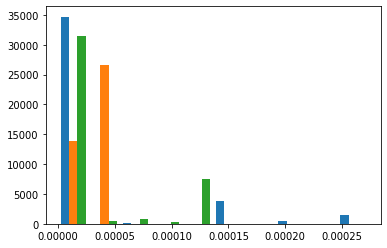

In [42]:
plt.hist(frag_prob)

In [43]:
id_str = np.array(fragment_fraglets.img_id.values, dtype='str')
style_counts = np.unique(np.array(train_ds.style.values, dtype='str'), return_counts=True)[1]
style_counts = style_counts / np.sum(style_counts)
points = []
for img_id in np.unique(id_str):
    p = frag_prob[id_str == img_id]
    pred = frag_prediction[id_str == img_id]
    #print(np.unique(pred, return_counts=True))
    p_sum = np.sum(p, axis = 0) #/ style_counts
    #print(np.argmax(p_sum))
    style = style_label_encoder.inverse_transform([np.argmax(p_sum)])
    points.append(p_sum)
    print(img_id, style, p_sum)

style_fragments_Archaic_0 ['Herodian'] [0.06376732 0.08116807 0.08357437]
style_fragments_Archaic_1 ['Archaic'] [0.10527753 0.09634456 0.06757339]
style_fragments_Archaic_2 ['Herodian'] [0.06021711 0.07703378 0.09348268]
style_fragments_Archaic_3 ['Archaic'] [0.09824537 0.0944693  0.07895871]
style_fragments_Hasmonean_0 ['Archaic'] [0.09735782 0.07847293 0.05874208]
style_fragments_Hasmonean_1 ['Archaic'] [0.10807674 0.07876948 0.08092806]
style_fragments_Hasmonean_2 ['Archaic'] [0.09647027 0.07460903 0.06760416]
style_fragments_Hasmonean_3 ['Archaic'] [0.10411688 0.08320032 0.08037418]
style_fragments_Herodian_0 ['Hasmonean'] [0.05031747 0.05906621 0.05769586]
style_fragments_Herodian_1 ['Herodian'] [0.08500034 0.10900908 0.13837775]
style_fragments_Herodian_2 ['Herodian'] [0.0740766  0.11004701 0.14283956]
style_fragments_Herodian_3 ['Hasmonean'] [0.05707653 0.05781022 0.04984922]


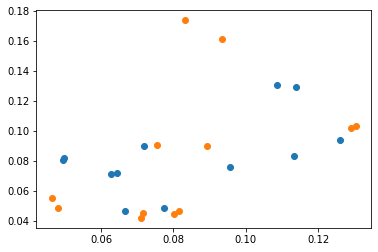

In [18]:
p = np.array(points)
plt.scatter(*p[:,:2].T)
plt.scatter(*p[:,1:].T)

In [19]:
style_label_encoder.inverse_transform([0])

array(['Archaic'], dtype='<U9')

In [20]:
pred = fraglet_style_knn.predict(fragment_embedding)


IndexError: index 800 is out of bounds for axis 0 with size 750

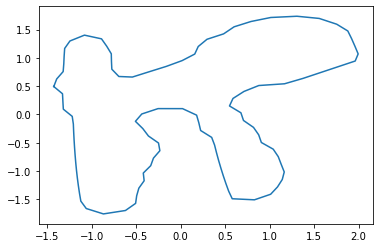

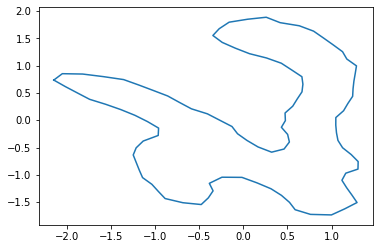

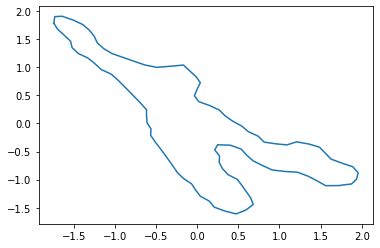

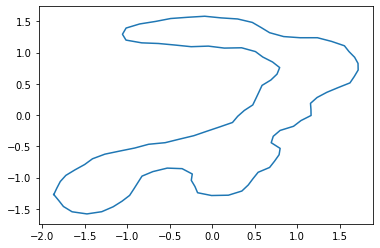

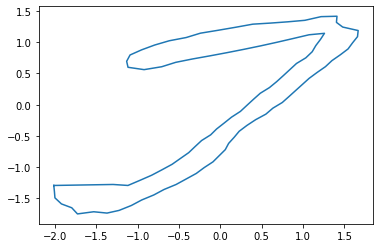

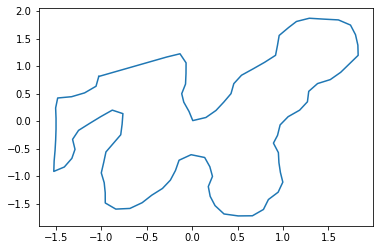

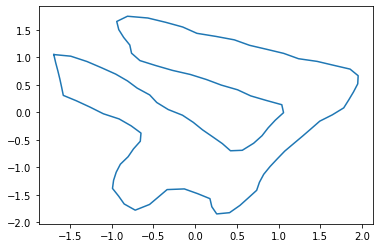

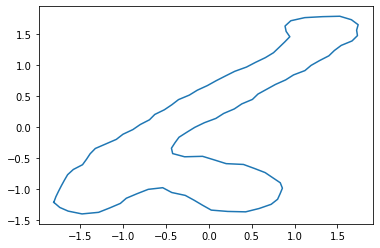

In [21]:
# for i in range(0, 1000, 100):
#     frag = codebook_fraglets['contour_norm'][i].values
#     plt.figure()
#     plt.plot(*np.flipud(frag.T))

In [ ]:
for i in range(0, 1000, 100):
    frag = codebook_fraglets['contour_norm'][i].values
    plt.figure()
    plt.plot(*np.flipud(frag.T))

# Combined embedding

In [ ]:
fragment_features = np.stack([fragment_fraglets['square_root_velocity'].values, fragment_fraglets['contour_norm'].values], axis = 2).reshape(-1,400)
train_features = np.stack([train_ds['square_root_velocity'].values, train_ds['contour_norm'].values], axis = 2).reshape(-1,400)
combined_features = np.concatenate([
    fragment_features,
    train_features
], axis = 0)

combined_labels = np.concatenate([
    np.repeat(-1, fragment_features.shape[0]),
    train_ds.style_label.astype('int') + 1
])

feature_projection = umap.UMAP(target_metric='categorical', target_weight=0.75)
combined_embedding = feature_projection.fit_transform(combined_features, y=combined_labels)
#feature_projection.transform(combined_features)
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*combined_embedding.T, s=0.5, c=combined_labels, alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
plt.title('Combined UMAP embbedding');
plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

test_embedding = feature_projection.transform(test_features)
train_embedding = feature_projection.transform(train_features)
fraglet_style_knn = KNeighborsClassifier(n_neighbors=3)
fraglet_style_knn.fit(train_embedding, train_ds.style_label)
style_pred = fraglet_style_knn.predict(test_embedding)
print("Style prediction accuracy:", fraglet_style_knn.score(test_embedding, test_ds.style_label))


fraglet_full = KNeighborsClassifier(n_neighbors=10)
fraglet_full.fit(train_embedding, train_ds.full_label)
full_pred = fraglet_full.predict(test_embedding)
print("Full prediction accuracy: ", fraglet_full.score(test_embedding, test_ds.full_label))

fraglet_allo_knn = KNeighborsClassifier(n_neighbors=10)
fraglet_allo_knn.fit(train_embedding, train_ds.allo_label)
print("Allograph prediction accuracy:", fraglet_allo_knn.score(test_embedding, test_ds.allo_label))



In [ ]:
fragment_embedding = feature_projection.transform(fragment_features)
frag_prob = fraglet_style_knn.predict_proba(fragment_embedding)
frag_prob /= np.sum(frag_prob, axis = 0)

In [ ]:
id_str = np.array(fragment_fraglets.img_id.values, dtype='str')
style_counts = np.unique(np.array(train_ds.style.values, dtype='str'), return_counts=True)[1]
style_counts = style_counts / np.sum(style_counts)
points = []
for img_id in np.unique(id_str):
    p = frag_prob[id_str == img_id]
    p_sum = np.sum(p, axis = 0) #/ style_counts
    #print(np.argmax(p_sum))
    style = style_label_encoder.inverse_transform([np.argmax(p_sum)])
    points.append(p_sum)
    print(img_id, style, p_sum)